In [1]:
%load_ext autoreload
%autoreload 2
import torch
from modules.competition_dataset_one_per_trial import EEGDataset, LABELS
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.covariance import EmpiricalCovariance
import random
import numpy as np
from sklearn.manifold import TSNE
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import f_classif
from sklearn.manifold import trustworthiness
from sklearn.metrics import silhouette_score
from scipy.stats import wasserstein_distance

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

/home/zeyadcode/.pyenv/versions/icmtc_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cpu')

In [2]:
data_path = './data/mtcaic3'
lda_model_path = './checkpoints/mi/models/lda_mi.pkl'

# Add this at the beginning of your notebook, after imports
def set_random_seeds(seed=42):
    """Set random seeds for reproducibility"""

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_random_seeds(42)

In [3]:
eeg_channels = ["C3", "CZ", "C4"]

dataset_train = EEGDataset(
    data_path=data_path,
    task="MI",
    split="train",
    tmin=0.5,  # skip first 0.5 s (125 samples)
    data_fraction=0.2,
    win_len=int(4.5 * 250),  # 4.5 s window → 1125 samples
    read_labels=True,
    eeg_channels=eeg_channels,
)

dataset_val = EEGDataset(
    data_path="./data/mtcaic3",
    task="MI",
    split="validation",
    tmin=0.5,
    win_len=int(4.5 * 250),
    read_labels=True,
)

dataset_test = EEGDataset(
    data_path="./data/mtcaic3",
    task="MI",
    split="test",
    tmin=0.5,
    win_len=int(4.5 * 250),
    read_labels=False,
)

data shape: torch.Size([480, 3, 40, 1125]), label shape: torch.Size([480])
data shape: torch.Size([50, 8, 40, 1125]), label shape: torch.Size([50])
data shape: torch.Size([50, 8, 40, 1125]), label shape: torch.Size([50])


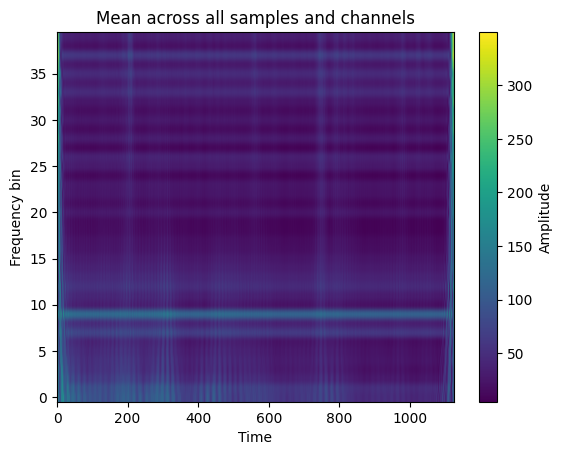

In [4]:
mean_overall = dataset_train.data.mean(dim=(0,  1))  # shape: [B, n_freqs, n_timesteps]

plt.imshow(mean_overall, aspect='auto', origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency bin')
plt.title('Mean across all samples and channels')
plt.colorbar(label='Amplitude')
plt.show()

In [5]:
X = dataset_train.data  # shape: [B, n_electrodes, n_freqs, n_timesteps]
y = dataset_train.labels  # shape: [B]

# Aggregate over freq and time for each channel
X_channel = X.mean(dim=(2, 3))  # shape: [B, n_electrodes]

f_scores, _ = f_classif(X_channel.numpy(), y.numpy())
for i, score in enumerate(f_scores):
    print(f"Channel {i}: F-score = {score:.2f}")

Channel 0: F-score = 3.15
Channel 1: F-score = 1.84
Channel 2: F-score = 2.31


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 480 samples in 0.029s...
[t-SNE] Computed neighbors for 480 samples in 1.822s...
[t-SNE] Computed conditional probabilities for sample 480 / 480
[t-SNE] Mean sigma: 3222.836095
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.423504
[t-SNE] KL divergence after 1000 iterations: -0.713414


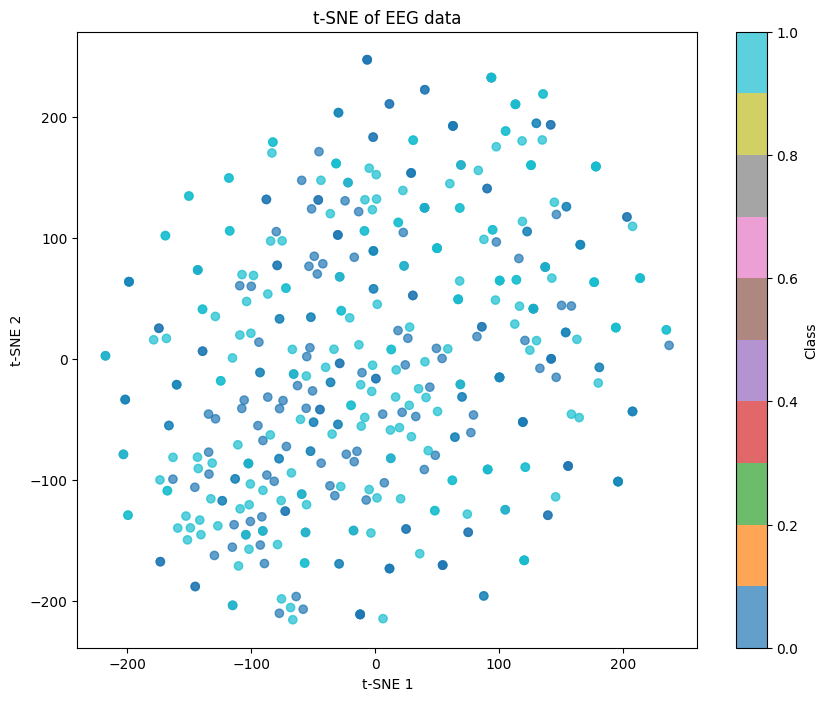

In [6]:
X_flat = X.reshape(X.shape[0], -1)  # [B, n_electrodes * n_freqs * n_timesteps]
tsne = TSNE(n_components=2, verbose=1, perplexity=30, learning_rate='auto', init='pca')
tsne_results = tsne.fit_transform(X_flat.numpy())

plt.figure(figsize=(10, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y.numpy(), cmap='tab10', alpha=0.7)
plt.title('t-SNE of EEG data')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar(label='Class')
plt.show()

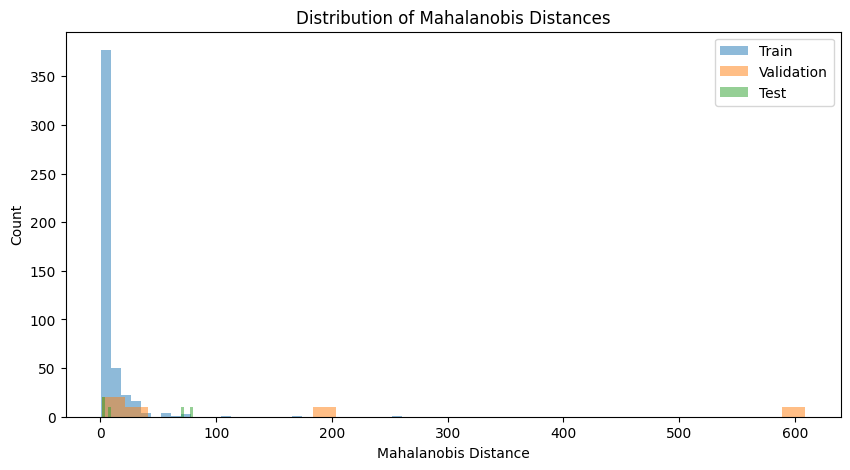

In [26]:
# Average over freq and time, so each sample is a vector of n_electrodes
X_train = dataset_train.data.mean(dim=(2, 3))  # [B, n_electrodes]
X_val   = dataset_val.data.mean(dim=(2, 3))
X_test  = dataset_test.data.mean(dim=(2, 3))

ec = EmpiricalCovariance().fit(X_train.numpy())

# 2. Compute Mahalanobis distances
d_train = ec.mahalanobis(X_train.numpy())
d_val   = ec.mahalanobis(X_val.numpy())
d_test  = ec.mahalanobis(X_test.numpy())

plt.figure(figsize=(10, 5))
plt.hist(d_train, bins=30, alpha=0.5, label='Train')
plt.hist(d_val, bins=30, alpha=0.5, label='Validation')
plt.hist(d_test, bins=30, alpha=0.5, label='Test')
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Count')
plt.title('Distribution of Mahalanobis Distances')
plt.legend()
plt.show()